### 以下代码和流程参考 https://blog.csdn.net/kicilove/article/details/78413112
### 以下代码和流程参考 https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [1]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4
from sklearn.cross_validation import train_test_split

d:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
d:\Anaconda3\lib\site-packages\sklearn\grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
dataset = pd.read_excel('D:/data2.0.xlsx')


In [3]:
target = 'Binding Sites'

In [5]:
#Choose all features_name except target 
feature_name = [x for x in dataset.columns if x not in [target]]

In [6]:
train,test = train_test_split(dataset,test_size=0.33,random_state=7)

In [7]:
xgb1 = XGBClassifier(max_depth=3,
                    learning_rate=0.1,
                    n_estimators=1000,
                    silent=False,
                    objective='binary:logistic',
                    booster='gbtree',
                    n_jobs=4,
                    gamma=0,
                    min_child_weight=1,
                    subsample=0.8,
                    nthread=4,
                    colsample_bytree=0.8,
                    scale_pos_weight=1,
                    seed=7)


In [8]:
xgb1.get_xgb_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.8,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 1000,
 'nthread': 4,
 'objective': 'binary:logistic',
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': 7,
 'silent': False,
 'subsample': 0.8,
 'verbosity': 1}

In [9]:
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[feature_name].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds, verbose_eval=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[feature_name], dtrain['Binding Sites'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[feature_name])
    dtrain_predprob = alg.predict_proba(dtrain[feature_name])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Binding Sites'].values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Binding Sites'], dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

d:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.8925
AUC Score (Train): 0.956089


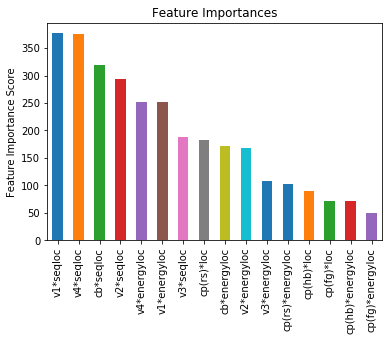

In [10]:
modelfit(xgb1, train,feature_name)

### 因为想知道测试集的准确率，所以在下面modelfit中将train改成test，看看能不能得到测试集的准确率（但没有修改modelfit的函数，想着单纯将train数据换成test数据罢了，不知道这样做对不对，待考究）

d:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.8706
AUC Score (Train): 0.948138


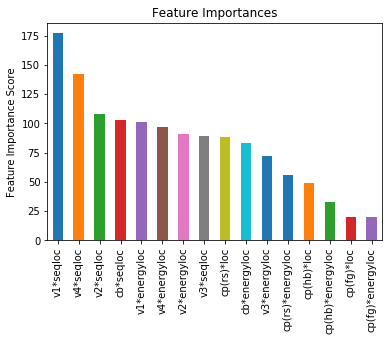

In [30]:
xgb1 = XGBClassifier(max_depth=3,
                    learning_rate=0.1,
                    n_estimators=1000,
                    silent=False,
                    objective='binary:logistic',
                    booster='gbtree',
                    n_jobs=4,
                    gamma=0,
                    min_child_weight=1,
                    subsample=0.8,
                    nthread=4,
                    colsample_bytree=0.8,
                    scale_pos_weight=1,
                    seed=7)
modelfit(xgb1, test,feature_name)

## 如何显示测试集的aucscore

In [13]:
param_test1 = {
 'max_depth':[1,2,3,4,5],
 'min_child_weight':[1,2,3,4,5]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch1.fit(train[feature_name],train[target])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: 0.69305, std: 0.02440, params: {'max_depth': 1, 'min_child_weight': 1},
  mean: 0.69399, std: 0.02433, params: {'max_depth': 1, 'min_child_weight': 2},
  mean: 0.69399, std: 0.02432, params: {'max_depth': 1, 'min_child_weight': 3},
  mean: 0.69399, std: 0.02432, params: {'max_depth': 1, 'min_child_weight': 4},
  mean: 0.69413, std: 0.02437, params: {'max_depth': 1, 'min_child_weight': 5},
  mean: 0.76781, std: 0.02581, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: 0.77057, std: 0.02797, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: 0.77027, std: 0.02777, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: 0.76922, std: 0.02468, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: 0.77050, std: 0.02521, params: {'max_depth': 2, 'min_child_weight': 5},
  mean: 0.80256, std: 0.02217, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: 0.80283, std: 0.02009, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: 0.79894, std: 0.02398, params: {

In [18]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[0.5,1,1.5]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[feature_name],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: 0.82169, std: 0.01716, params: {'max_depth': 4, 'min_child_weight': 0.5},
  mean: 0.81912, std: 0.01790, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: 0.81923, std: 0.01685, params: {'max_depth': 4, 'min_child_weight': 1.5},
  mean: 0.83022, std: 0.01462, params: {'max_depth': 5, 'min_child_weight': 0.5},
  mean: 0.82895, std: 0.01550, params: {'max_depth': 5, 'min_child_weight': 1},
  mean: 0.82946, std: 0.01624, params: {'max_depth': 5, 'min_child_weight': 1.5},
  mean: 0.83365, std: 0.01493, params: {'max_depth': 6, 'min_child_weight': 0.5},
  mean: 0.83432, std: 0.01520, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: 0.83317, std: 0.01686, params: {'max_depth': 6, 'min_child_weight': 1.5}],
 {'max_depth': 6, 'min_child_weight': 1},
 0.8343226277287444)

### 因为暂时max_depth最优值是6，所以可试试比6大的网格搜索。

In [20]:
param_test2b = {
 'max_depth':[6,8,10,12]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[feature_name],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_



([mean: 0.83367, std: 0.01568, params: {'max_depth': 6},
  mean: 0.83769, std: 0.01482, params: {'max_depth': 8},
  mean: 0.83694, std: 0.01600, params: {'max_depth': 10},
  mean: 0.83773, std: 0.01518, params: {'max_depth': 12}],
 {'max_depth': 12},
 0.837728697104849)

In [21]:
param_test2c = {
 'max_depth':[12,14,16,18]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2c, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[feature_name],train[target])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_



([mean: 0.83773, std: 0.01518, params: {'max_depth': 12},
  mean: 0.83681, std: 0.01571, params: {'max_depth': 14},
  mean: 0.83633, std: 0.01317, params: {'max_depth': 16},
  mean: 0.83581, std: 0.01437, params: {'max_depth': 18}],
 {'max_depth': 12},
 0.837728697104849)

### 最终得到最优的max_depth为12，min_child_weight为1

In [22]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=12,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch3.fit(train[feature_name],train[target])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: 0.83766, std: 0.01549, params: {'gamma': 0.0},
  mean: 0.83880, std: 0.01514, params: {'gamma': 0.1},
  mean: 0.83906, std: 0.01572, params: {'gamma': 0.2},
  mean: 0.83758, std: 0.01494, params: {'gamma': 0.3},
  mean: 0.83736, std: 0.01568, params: {'gamma': 0.4}],
 {'gamma': 0.2},
 0.8390642974013807)

d:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9417
AUC Score (Train): 0.983480


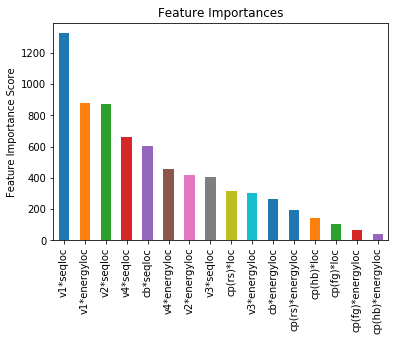

In [23]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=12,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb2, train, feature_name)

In [24]:
param_test4 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}
gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=12,
 min_child_weight=1, gamma=0.2, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test4, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[feature_name],train[target])
gsearch4.grid_scores_, gsearch4.best_params_, gsearch4.best_score_

([mean: 0.83850, std: 0.01485, params: {'colsample_bytree': 0.6, 'subsample': 0.6},
  mean: 0.83875, std: 0.01390, params: {'colsample_bytree': 0.6, 'subsample': 0.7},
  mean: 0.83478, std: 0.01381, params: {'colsample_bytree': 0.6, 'subsample': 0.8},
  mean: 0.83909, std: 0.01721, params: {'colsample_bytree': 0.6, 'subsample': 0.9},
  mean: 0.83705, std: 0.01293, params: {'colsample_bytree': 0.7, 'subsample': 0.6},
  mean: 0.83732, std: 0.01403, params: {'colsample_bytree': 0.7, 'subsample': 0.7},
  mean: 0.83740, std: 0.01372, params: {'colsample_bytree': 0.7, 'subsample': 0.8},
  mean: 0.83862, std: 0.01398, params: {'colsample_bytree': 0.7, 'subsample': 0.9},
  mean: 0.83848, std: 0.01515, params: {'colsample_bytree': 0.8, 'subsample': 0.6},
  mean: 0.83785, std: 0.01446, params: {'colsample_bytree': 0.8, 'subsample': 0.7},
  mean: 0.83843, std: 0.01518, params: {'colsample_bytree': 0.8, 'subsample': 0.8},
  mean: 0.83619, std: 0.01417, params: {'colsample_bytree': 0.8, 'subsample'

### 'colsample_bytree最优值为0.6，subsample最优值为0.9

In [25]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=12,
 min_child_weight=1, gamma=0.2, subsample=0.9, colsample_bytree=0.6,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test6, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[feature_name],train[target])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: 0.83909, std: 0.01721, params: {'reg_alpha': 1e-05},
  mean: 0.83713, std: 0.01549, params: {'reg_alpha': 0.01},
  mean: 0.83827, std: 0.01455, params: {'reg_alpha': 0.1},
  mean: 0.83816, std: 0.01593, params: {'reg_alpha': 1},
  mean: 0.54915, std: 0.02520, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 0.8390908449072118)

### 'reg_alpha'最优值即初始值0.005

d:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.924
AUC Score (Train): 0.976092


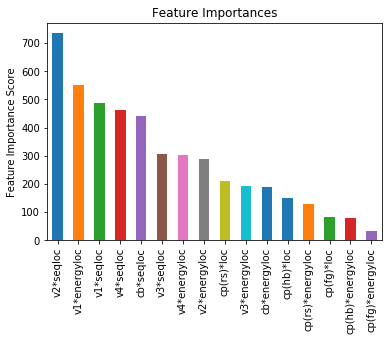

In [26]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=12,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.9,
 colsample_bytree=0.6,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb3, train, feature_name)

d:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9279
AUC Score (Train): 0.976813


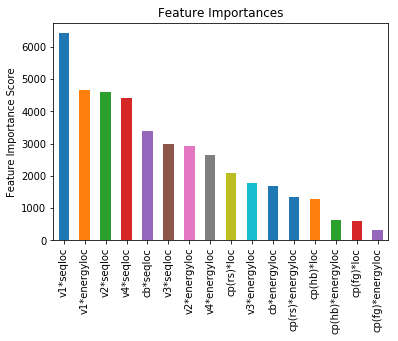

In [28]:
xgb4 = XGBClassifier(
 learning_rate =0.011,
 n_estimators=1000,
 max_depth=12,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.9,
 colsample_bytree=0.6,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, train, feature_name)

### 因为想知道测试集的准确率，所以在下面modelfit中将train改成test，看看能不能得到测试集的准确率（但没有修改modelfit的函数，想着单纯将train数据换成test数据罢了，不知道这样做对不对，待考究）

d:\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Model Report
Accuracy : 0.9089
AUC Score (Train): 0.969283


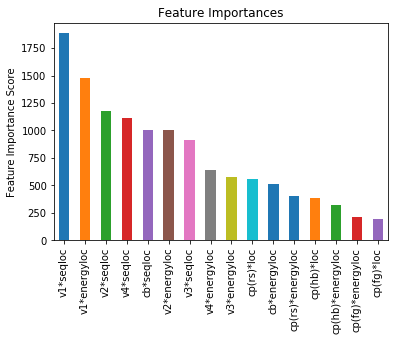

In [29]:
xgb4 = XGBClassifier(
 learning_rate =0.011,
 n_estimators=1000,
 max_depth=12,
 min_child_weight=1,
 gamma=0.2,
 subsample=0.9,
 colsample_bytree=0.6,
 reg_alpha=0.005,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
modelfit(xgb4, test, feature_name)

### 在调优前后准确率都是很高的，而且如果这个真的是测试集的准确率的话，应该没出现过拟合现象，因为训练集和测试集准确率相近。
### 有两个疑问：
#### 1）这个真的是测试集的准确率吗？
#### 2）需要引入cross evaluation去验证准确率以避免抽样bias吗？

1) 这样测出来的测试集准确率意义比较有限。划分训练集和测试集是为了了解模型的泛化（generalization）性能，也就是模型预测“没有见过”的样例时的准确率，因此我们在训练集上利用标签信息来训练模型，然后用训练好的模型对训练集进行预测，用得到的预测结果和测试集的标签进行准确率计算。如果用上述方法计算测试集的准确率，那么模型是“已经见过了”测试集的样例的，因为它在测试集上同样利用了标签信息进行训练，所以没有办法了解模型的泛化性能。而泛化性能之所以重要是因为一般来说模型只会训练一次，然后就会部署上线使用，这之后每一次的预测都是没见过的样例，所以它可以看作模型的“实战性能”。
2) 很有必要！你可以去了解下 训练集/验证集/测试集的划分的意义

In [ ]:
#如果你要测模型在测试集上的性能可以大概这么写，sry，未来得及验证是不是能跑，一般来说模型会封装有fit方法：用来拟合训练集，和predict方法：用来预测样例
dtest_predictions = xgb.predict(dtest[feature_name]) #调用模型的predict方法预测测试集的样例 得到预测结果存在dtest_predictions
print ("Accuracy : %.4g" % metrics.accuracy_score(dtest['Binding Sites'].values, dtest_predictions)) #计算并打印测试集标签与预测结果的比较结果 即准确率
